In [14]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm import tqdm
from copy import deepcopy
from utils import get_available_gpu_memory, estimate_optimal_batch_size

Decoding Pump activation given neural data

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")

In [17]:
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values
t = df.Time.to_list()

In [18]:
delta = 5000
def get_x_ticks(L:int):
    x_ticks = np.arange(0,L,delta)
    x_tick_labels = [f"{t[i]/100:.2f}" for i in x_ticks]
    return x_ticks, x_tick_labels

In [19]:
split = int(0.2*len(X))
X_train, X_test = X[:-split], X[-split:]
y_train, y_test = df["Pump"].values[:-split], df["Pump"].values[-split:]
X_train.shape, X_test.shape

((52796, 709), (13198, 709))

In [20]:
def fibonacci(n):
    fib_sequence = [1, 2]
    while len(fib_sequence) < n:
        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
    return fib_sequence[:n]

## Autoencoder

This model works on the hypothesis that a response $X(t)$ is caused by a lagged stimulus $y(t - \tau)$. Thus, it tries to map $X(t + \tau) \mapsto y(t)$ by reversing time and taking a certain lag window of size $\tau$. The bottleneck of this model happens inside of the GRU, as a reduction of the hidden dimension.

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window_size = 512):
        self.X = X
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return self.X.shape[0] - self.window_size

    def __getitem__(self, idx):
        y = self.y[idx]
        U = self.X[idx:idx+self.window_size]
        U = torch.tensor(U.copy(), dtype=torch.float32).T.to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        return U, y

Checking the effect of window size on the model.

In [22]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, conv_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.conv_dim = conv_dim
        self.hidden_size = hidden_size
        self.dropout = torch.nn.Dropout(0.05)

        self.conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=input_dim, kernel_size=conv_dim)
        self.rnn = torch.nn.GRU(input_size=input_dim, hidden_size=hidden_size, num_layers=1)
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.dropout(x)
        x = self.conv(x) #N, C, L
        x = torch.permute(x, (2, 0, 1))
        x, _ = self.rnn(x)
        x = torch.permute(x, (1, 0, 2))
        x = x[:,-1,:]
        x = self.fc(x)
        return x.squeeze(1)

In [23]:
input_dim = X_train.shape[1]
window_sizes = fibonacci(10)
total_losses = []
scores = []
best_model = None
best_y_pred = []
for window_size in window_sizes:
    conv_size = min(8, window_size)
    model = AutoEncoder(input_dim, conv_size, 8).to(device)
    gpu_memory = get_available_gpu_memory()
    data = Dataset(X_train, y_train, window_size=window_size)
    sample_data = data[0][0]
    batch_size = estimate_optimal_batch_size(model, sample_data.shape, gpu_memory, device)
    batch_size = min(batch_size, 256)
    print(f"Free memory: {gpu_memory}, Batch Size: {batch_size}, Window Size: {window_size}")
    
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    loss = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    losses = []
    pbar = tqdm(range(5))
    for epoch in pbar:
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred_logits = model(X_batch)
            l = loss(y_pred_logits, y_batch)
            l.backward()
            optimizer.step()
            losses.append(l.item())
        pbar.set_postfix({"Loss":l.item(), "Window Size": window_size})
        scheduler.step()
    total_losses.append(losses)


    # Prepare the test dataset
    test_data = Dataset(X_test, y_test, window_size=window_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False)

    # Get predictions for the test data
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_true.extend(y_batch.cpu().numpy())
            y_pred_logits = model(X_batch)
            y_pred_sig = torch.sigmoid(y_pred_logits)
            y_pred.extend(y_pred_sig.cpu().numpy())

    # Calculate R² score
    r2 = r2_score(y_true, y_pred)
    scores.append(r2)

    if r2 == max(scores):
        best_model = deepcopy(model)
        best_y_pred = y_pred
    del model

    #Wipe CUDA memory
    if device.type == "cuda":
        torch.cuda.empty_cache()

Free memory: 3650.890625, Batch Size: 256, Window Size: 1


100%|██████████| 5/5 [00:20<00:00,  4.15s/it, Loss=0.055, Window Size=1] 


Free memory: 3827.390625, Batch Size: 256, Window Size: 2


100%|██████████| 5/5 [00:22<00:00,  4.40s/it, Loss=0.143, Window Size=2] 


Free memory: 3794.9130859375, Batch Size: 256, Window Size: 3


100%|██████████| 5/5 [00:23<00:00,  4.74s/it, Loss=0.0894, Window Size=3]


Free memory: 3762.94970703125, Batch Size: 256, Window Size: 4


100%|██████████| 5/5 [00:24<00:00,  4.94s/it, Loss=0.165, Window Size=4]


Free memory: 3752.3876953125, Batch Size: 256, Window Size: 5


100%|██████████| 5/5 [00:25<00:00,  5.19s/it, Loss=0.0894, Window Size=5]


Free memory: 3721.77197265625, Batch Size: 256, Window Size: 6


100%|██████████| 5/5 [00:26<00:00,  5.22s/it, Loss=0.133, Window Size=6] 


Free memory: 3678.4150390625, Batch Size: 256, Window Size: 7


100%|██████████| 5/5 [00:26<00:00,  5.39s/it, Loss=0.131, Window Size=7]


Free memory: 3664.876953125, Batch Size: 237, Window Size: 8


100%|██████████| 5/5 [00:28<00:00,  5.67s/it, Loss=0.162, Window Size=8]


Free memory: 3647.83837890625, Batch Size: 236, Window Size: 9


100%|██████████| 5/5 [00:31<00:00,  6.29s/it, Loss=0.116, Window Size=9]


Free memory: 3646.3173828125, Batch Size: 236, Window Size: 10


100%|██████████| 5/5 [00:35<00:00,  7.10s/it, Loss=0.182, Window Size=10]


Free memory: 3645.7119140625, Batch Size: 236, Window Size: 11


100%|██████████| 5/5 [00:39<00:00,  7.90s/it, Loss=0.1, Window Size=11]  


Free memory: 3643.93994140625, Batch Size: 236, Window Size: 12


100%|██████████| 5/5 [00:42<00:00,  8.55s/it, Loss=0.103, Window Size=12] 


Free memory: 3627.73828125, Batch Size: 235, Window Size: 13


100%|██████████| 5/5 [00:46<00:00,  9.27s/it, Loss=0.0942, Window Size=13]


Free memory: 3626.72607421875, Batch Size: 235, Window Size: 14


100%|██████████| 5/5 [00:48<00:00,  9.70s/it, Loss=0.139, Window Size=14]


Free memory: 3623.72216796875, Batch Size: 235, Window Size: 15


100%|██████████| 5/5 [00:51<00:00, 10.33s/it, Loss=0.0533, Window Size=15]


Free memory: 3620.25927734375, Batch Size: 234, Window Size: 16


100%|██████████| 5/5 [00:55<00:00, 11.10s/it, Loss=0.16, Window Size=16] 


Free memory: 3496.38525390625, Batch Size: 226, Window Size: 17


100%|██████████| 5/5 [00:59<00:00, 11.92s/it, Loss=0.046, Window Size=17]


Free memory: 3510.05419921875, Batch Size: 227, Window Size: 18


100%|██████████| 5/5 [01:01<00:00, 12.36s/it, Loss=0.172, Window Size=18]


Free memory: 3509.06982421875, Batch Size: 227, Window Size: 19


100%|██████████| 5/5 [01:05<00:00, 13.07s/it, Loss=0.0525, Window Size=19]


Free memory: 3520.58544921875, Batch Size: 228, Window Size: 20


100%|██████████| 5/5 [01:09<00:00, 13.81s/it, Loss=0.0789, Window Size=20]


Free memory: 3519.61181640625, Batch Size: 228, Window Size: 21


100%|██████████| 5/5 [01:11<00:00, 14.32s/it, Loss=0.104, Window Size=21]


Free memory: 3518.6435546875, Batch Size: 228, Window Size: 22


100%|██████████| 5/5 [01:14<00:00, 14.87s/it, Loss=0.169, Window Size=22]


Free memory: 3515.6806640625, Batch Size: 228, Window Size: 23


 20%|██        | 1/5 [00:19<01:18, 19.66s/it, Loss=0.163, Window Size=23]


KeyboardInterrupt: 

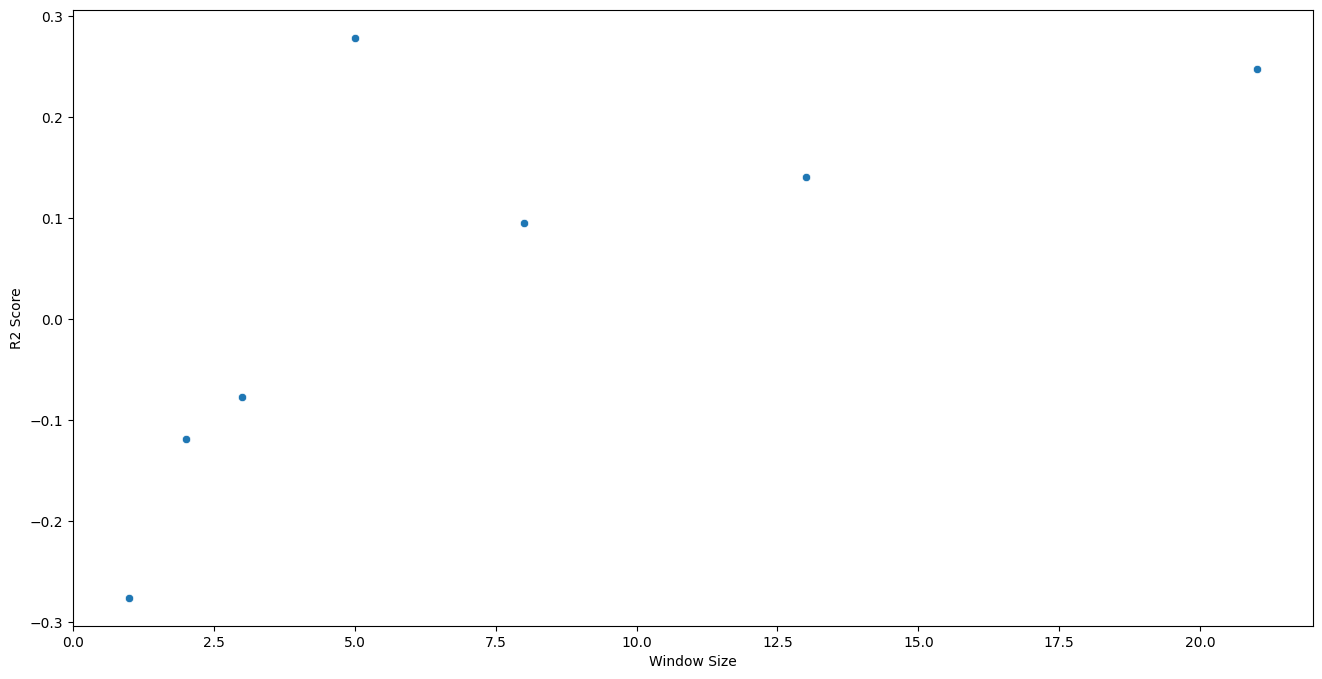

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=window_sizes, y=scores, ax=ax)
plt.xlabel('Window Size')
plt.ylabel('R2 Score')
plt.show()

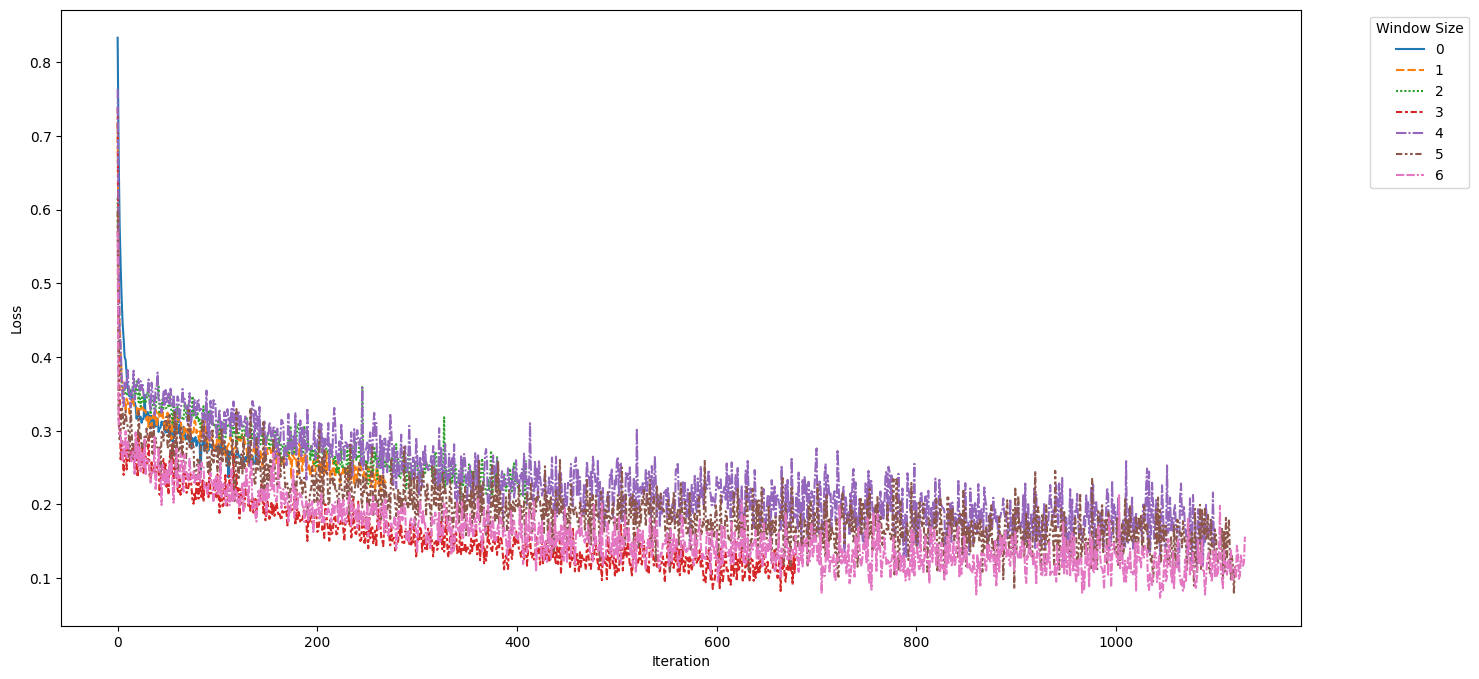

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=total_losses, ax=ax)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Window Size')
plt.show()

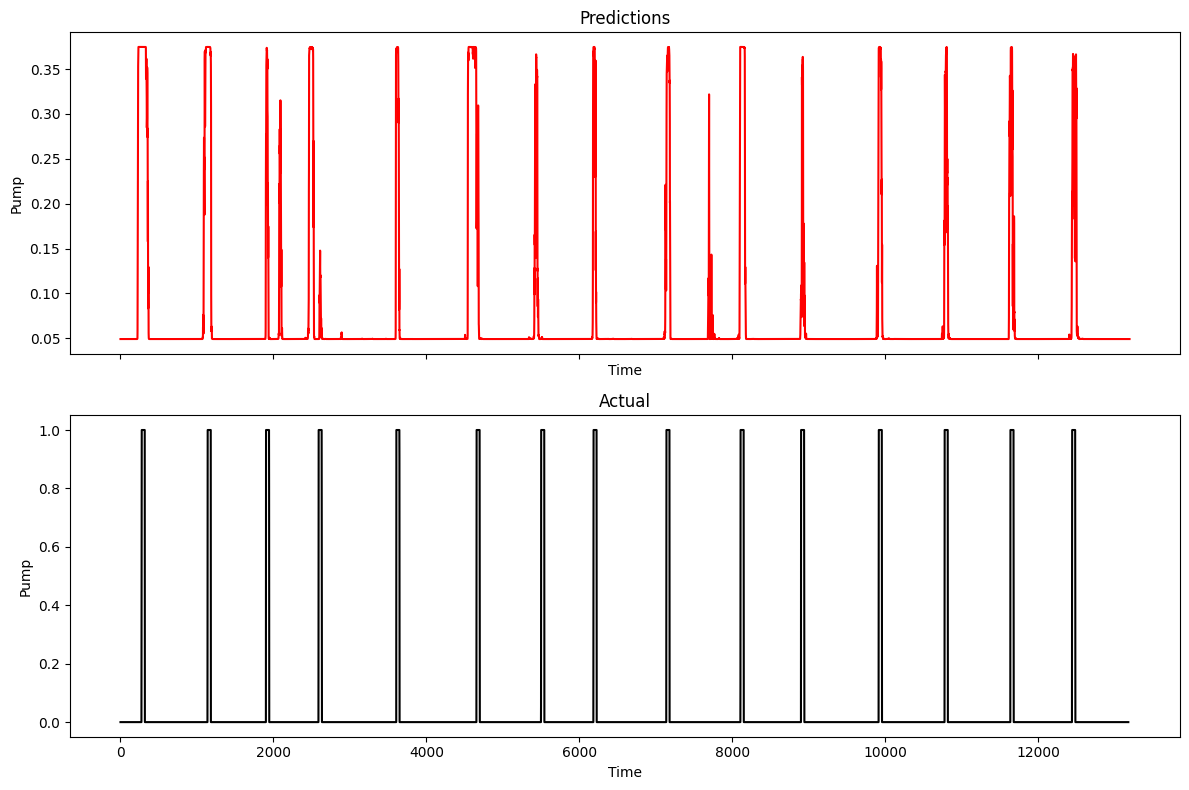

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot Pump data
ax2.plot(y_true, color='black')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Actual')

# Plot predictions
ax1.plot(best_y_pred, color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pump')
ax1.set_title('Predictions')

plt.tight_layout()
plt.show()